In [193]:
import general_tools as gt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data_retrievel_and_feature_extraction import uniprot_info as uni
from Bio.PDB import PDBIO, Model, Chain, Residue, Atom
import pandas as pd
from biopandas.pdb import PandasPdb
from Bio.PDB import PDBParser


In [194]:
genes = ["COL2A1", "COL4A3", "COL4A5", "WFS1", "SLC26A4", "MYO7A", "FGFR1", "GJB2"]
gene = genes[3]
pdb_file = f'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\AF_structures\\{gene}.pdb'

In [195]:
def pdb_to_dataframe(pdb_file):
    # Create a PDB parser and load the structure
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    # Initialize lists to store PDB data
    atom_data = []

    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atom_record = {
                        'ATOM': atom.get_serial_number(),
                        'NAME': atom.get_name(),
                        'RESNAME': residue.get_resname(),
                        'CHAINID': chain.id,
                        'RESIDUESEQ': residue.id[1],
                        'X': atom.get_coord()[0],
                        'Y': atom.get_coord()[1],
                        'Z': atom.get_coord()[2],
                        'OCCUPANCY': atom.get_occupancy(),
                        'TEMPFACTOR': atom.get_bfactor(),
                        'ELEMENT': atom.element,
                    }
                    atom_data.append(atom_record)

    # Create a DataFrame from the atom data
    df = pd.DataFrame(atom_data)

    return df


pdb_df = pdb_to_dataframe(pdb_file)
print(pdb_df)
print(pdb_df.columns)

      ATOM NAME RESNAME CHAINID  RESIDUESEQ          X          Y       Z  \
0        1    N     MET       A           1  67.658997 -16.459999  -1.016   
1        2   CA     MET       A           1  68.356003 -15.195000  -0.725   
2        3    C     MET       A           1  67.377998 -14.340000   0.040   
3        4   CB     MET       A           1  68.850998 -14.477000  -1.993   
4        5    O     MET       A           1  66.440002 -13.822000  -0.551   
...    ...  ...     ...     ...         ...        ...        ...     ...   
7064  7065   CA     ALA       A         890   1.289000  23.389999  -9.399   
7065  7066    C     ALA       A         890   2.227000  22.559000 -10.284   
7066  7067   CB     ALA       A         890   1.898000  24.733000  -8.975   
7067  7068    O     ALA       A         890   3.015000  21.735001  -9.759   
7068  7069  OXT     ALA       A         890   2.049000  22.635000 -11.518   

      OCCUPANCY  TEMPFACTOR ELEMENT  
0           1.0       37.88       N  

In [196]:

######### Functions for addition of b_factor column by pathogenicity to pdb_df dataframe #########

def create_dictionary_with_all_residues(protein_length):
    """
    Creates a dictionary where the keys are residue numbers and the values are
    the residue names. The dictionary contains all residues from 1 to the
    protein_length.
    The values for all residues are set to 'None' by default.
    """
    # Create an empty dictionary
    residue_dict = {}
    # Iterate through the range of numbers from 1 to the protein_length
    for residue_number in range(1, protein_length + 1):
        # Add the residue number and residue name to the residue_dict dictionary
        residue_dict[residue_number] = None
    return residue_dict

def get_b_factor_dict(residue_dict, pathogenicity_df, gene_length):
    """
    Go over all the residues: Create a subset of the pathogenicity_df by residue.
    For each subset, if there is only one value, then insert the pathogenicity value into the dictionary.
    If there are multiple values, then check if they are the same. If they are, then insert the pathogenicity value into the dictionary.
    If they are not, then insert 'Vague' into the dictionary.
    """
    for residue in range(gene_length):
        # Create a subset of the pathogenicity_df by residue
        pathogenicity_by_residue = pathogenicity_df[pathogenicity_df['position'] == residue]
        # Check if there is only one value in the pathogenicity_by_residue dataframe
        if len(pathogenicity_by_residue) == 1:
            # Get the pathogenicity value from the pathogenicity_by_residue dataframe
            pathogenicity = pathogenicity_by_residue['pathogenicity'].values[0]
            # Insert the pathogenicity value into the residue_dict dictionary
            residue_dict[residue] = pathogenicity
        elif len(pathogenicity_by_residue) > 1:
            # Get the pathogenicity values from the pathogenicity_by_residue dataframe
            pathogenicity_values = pathogenicity_by_residue['pathogenicity'].values
            # Check if all the pathogenicity values are the same
            if all(pathogenicity == pathogenicity_values[0] for pathogenicity in pathogenicity_values):
                # Insert the pathogenicity value into the residue_dict dictionary
                residue_dict[residue] = pathogenicity_values[0]
            else:
                # Insert 2 for Vague information into the residue_dict dictionary
                residue_dict[residue] = 2
    return residue_dict

def add_b_factor_by_residue(pdb_df, b_factor_dict):
    """
    Adds a b_factor column to the pdb_df dataframe. The b_factor column
    contains the b_factor values for each residue in the pdb_df dataframe.
    The b_factor values are taken from the b_factor_dict dictionary.
    Addition is done by residue, so all atoms in a residue will have the same b_factor.
    """
    # Make sure there's a bfactor column in the pdb_df dataframe
    if 'TEMPFACTOR' not in pdb_df.columns:
        # raise an error if there's no bfactor column
        raise ValueError('There is no bfactor column in the pdb_df dataframe')
    # Iterate through the rows of the pdb_df dataframe
    for index, row in pdb_df.iterrows():
        # Get the residue number for the current row
        residue_number = row['RESIDUESEQ']
        # Get the b_factor value for the current row
        b_factor = b_factor_dict[residue_number]
        # Set the b_factor value for all rows with the current residue number
        pdb_df.loc[pdb_df['RESIDUESEQ'] == residue_number, 'TEMPFACTOR'] = b_factor
    return pdb_df


def dataframe_to_pdb(dataframe, output_file):
    ppdb = PandasPdb()
    ppdb.df['ATOM'] = dataframe
    ppdb.to_pdb(output_file, records=['ATOM'])

In [197]:
# Define a function to update the B-factor (11th column) value
def update_bfactor(line, new_value):
    line_list = list(line)
    line_list[60:70] = f'{new_value:6.2f}'.encode('utf-8')
    return bytes(line_list)

In [198]:
def create_pdb_with_bfactor(pdb_file):
    # Path to your input and output files
    input_file_path = pdb_file
    output_file_path = "COL4A5_with_b_factor.pdb"
    
    # Flag to indicate whether you're inside the "ATOM" table
    inside_atom_table = False
    
    # Read the input file and write to the output file
    with open(input_file_path, "r") as input_file, open(output_file_path, "wb") as output_file:
        for line in input_file:
            # Check if the line starts with "ATOM" to identify the start of the table
            if line.startswith("ATOM"):
                inside_atom_table = True
    
            if inside_atom_table:
                # Perform your calculations here
                # For example, let's increment the B-factor by 10 for demonstration
                bfactor = float(line[60:70])
                new_bfactor = bfactor + 10.0
                line = update_bfactor(line, new_bfactor)
    
            # Write the line to the output file
            output_file.write(line.encode('utf-8'))

In [199]:
gene_length = uni.get_sequence_length(gene)
pathogenicity_df = pd.read_csv(f'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\gene_specific_df\\{gene}_with_position.csv')
pathogenicity_df


,gene,variant,pathogenicity,uniprot_id,stability_WT,stability_MUT,blosum,hydrophobicity_WT,hydrophobicity_MUT,volume_WT,...,oda_MUT,sasa_WT,sasa_MUT,RSA_WT,RSA_MUT,oda_delta,sasa_delta,pssm,entropy,position
0,WFS1,T5A,benign,O76024,406.243,406.410,0,-0.7,1.8,116.1,...,-0.65,144.59,110.51,0.887055,0.913306,-1.27,-34.08,3.675,3.042,5
1,WFS1,P7A,benign,O76024,406.550,406.820,-1,-1.6,1.8,112.7,...,-3.77,129.82,103.89,0.842987,0.858595,0.79,-25.93,4.586,2.483,7
2,WFS1,P7Q,benign,O76024,406.550,406.421,-1,-1.6,-3.5,112.7,...,-0.57,129.82,171.78,0.842987,0.802710,3.99,41.96,4.586,2.483,7
3,WFS1,P16L,benign,O76024,405.800,406.781,-3,-1.6,3.8,112.7,...,-8.98,118.89,163.92,0.772013,0.858220,0.81,45.03,4.641,2.163,16
4,WFS1,P17L,benign,O76024,405.187,405.847,-3,-1.6,3.8,112.7,...,-7.48,127.58,131.68,0.828442,0.689424,-1.29,4.10,3.746,2.255,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,WFS1,Q14R,benign,NaN,405.740,405.538,1,-3.5,-4.5,143.8,...,-10.21,170.60,184.05,0.797196,0.694528,-0.23,13.45,5.242,2.839,14
306,WFS1,L499F,benign,NaN,406.155,405.569,0,3.8,2.8,166.7,...,-114.10,44.63,53.58,0.233665,0.235000,-4.40,8.95,4.098,0.870,499
307,WFS1,D866N,benign,NaN,403.125,405.666,1,-3.5,-3.5,111.1,...,-92.65,101.80,94.71,0.544385,0.506471,-13.02,-7.09,6.115,1.105,866
308,WFS1,G76V,benign,NaN,406.550,406.536,-3,-0.4,4.2,60.1,...,-1.63,73.47,133.73,0.757423,0.810485,-1.64,60.26,3.942,2.494,76


In [211]:
# leave only the pathogenicity and residue number columns
pathogenicity_df = pathogenicity_df[['position', 'pathogenicity']]
# Change pathogenicity to 1 and 0, where 1 is pathogenic and 0 is benign
pathogenicity_df['pathogenicity'] = pathogenicity_df['pathogenicity'].map({'pathogenic': 1, 'benign': 0})

residue_dict = create_dictionary_with_all_residues(gene_length)

b_factor_dict = get_b_factor_dict(residue_dict, pathogenicity_df, gene_length)
pdb_df = add_b_factor_by_residue(pdb_df, b_factor_dict)

b_factor_dict

{1: None, 2: None, 3: None, 4: None, 5: nan, 6: None, 7: 2, 8: None, 9: None, 10: None, 11: None, 12: None, 13: None, 14: nan, 15: None, 16: nan, 17: 2, 18: None, 19: nan, 20: None, 21: None, 22: None, 23: nan, 24: None, 25: None, 26: None, 27: None, 28: None, 29: None, 30: None, 31: None, 32: None, 33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: nan, 41: nan, 42: None, 43: None, 44: 2, 45: None, 46: None, 47: nan, 48: None, 49: nan, 50: None, 51: nan, 52: None, 53: nan, 54: nan, 55: None, 56: None, 57: 2, 58: nan, 59: None, 60: None, 61: None, 62: None, 63: None, 64: nan, 65: nan, 66: nan, 67: nan, 68: None, 69: None, 70: None, 71: nan, 72: None, 73: None, 74: None, 75: None, 76: 2, 77: None, 78: None, 79: None, 80: None, 81: nan, 82: None, 83: None, 84: nan, 85: None, 86: nan, 87: None, 88: None, 89: None, 90: None, 91: nan, 92: None, 93: None, 94: None, 95: None, 96: None, 97: None, 98: None, 99: None, 100: None, 101: None, 102: None, 103: None, 104: None, 

{1: None,
 2: None,
 3: None,
 4: None,
 5: nan,
 6: None,
 7: 2,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: nan,
 15: None,
 16: nan,
 17: 2,
 18: None,
 19: nan,
 20: None,
 21: None,
 22: None,
 23: nan,
 24: None,
 25: None,
 26: None,
 27: None,
 28: None,
 29: None,
 30: None,
 31: None,
 32: None,
 33: None,
 34: None,
 35: None,
 36: None,
 37: None,
 38: None,
 39: None,
 40: nan,
 41: nan,
 42: None,
 43: None,
 44: 2,
 45: None,
 46: None,
 47: nan,
 48: None,
 49: nan,
 50: None,
 51: nan,
 52: None,
 53: nan,
 54: nan,
 55: None,
 56: None,
 57: 2,
 58: nan,
 59: None,
 60: None,
 61: None,
 62: None,
 63: None,
 64: nan,
 65: nan,
 66: nan,
 67: nan,
 68: None,
 69: None,
 70: None,
 71: nan,
 72: None,
 73: None,
 74: None,
 75: None,
 76: 2,
 77: None,
 78: None,
 79: None,
 80: None,
 81: nan,
 82: None,
 83: None,
 84: nan,
 85: None,
 86: nan,
 87: None,
 88: None,
 89: None,
 90: None,
 91: nan,
 92: None,
 93: None,
 94: None,
 95: None,
 

In [216]:
benign_residues = 0
pathogenic_residues = 0
vague_residues = 0
no_data_residues = 0

for key in b_factor_dict:
    if b_factor_dict[key] == 0:
        benign_residues += 1
    elif b_factor_dict[key] == 1:
        pathogenic_residues += 1
    elif b_factor_dict[key] == 2:
        vague_residues += 1
    elif b_factor_dict[key] == 3:
        no_data_residues += 1

no_data_residues       

0

In [201]:
# Create a bfactor array by going through the pdb_df dataframe, for every RESIDUESEQ, get the BFACTOR value from the dictionary.
bfactor_array = []
for index, row in pdb_df.iterrows():
    residue_number = row['RESIDUESEQ']
    bfactor = b_factor_dict[residue_number]
    bfactor_array.append(bfactor)

for i in bfactor_array:
    if i == None:
        # change the None values to 3
        bfactor_array[bfactor_array.index(i)] = 3
        
print(bfactor_array)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 

In [202]:
# # save bfactor array to a csv file
# bfactor_df = pd.DataFrame({'Bfactor': bfactor_array})
# bfactor_df.to_csv(f'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\data_analysis\\{gene}_data_spread_in_3D.csv')

In [210]:
# get amount of each value 0, 1, 2, 3 in the bfactor dictionary. For example, if there's 10 residues with value 0, percentage_0 will be 10
percentage_0 = b_factor_dict.values().count(0)
percentage_1 = b_factor_dict.values().count(1)
percentage_2 = b_factor_dict.values().count(2)
percentage_3 = b_factor_dict.values().count(3)

# print count of each value 0, 1, 2, 3 in the bfactor array
print(f"Data for gene: {gene}")
print(f"Number of all benign variants residues: {bfactor_array.count(0)}")
print(f"Number of all benign variants residues: {bfactor_array.count(1)}")
print(f"Number of mixed variants residues: {bfactor_array.count(2)}")
print(f"Number of no data residues: {bfactor_array.count(3)}")

AttributeError: 'dict_values' object has no attribute 'count'

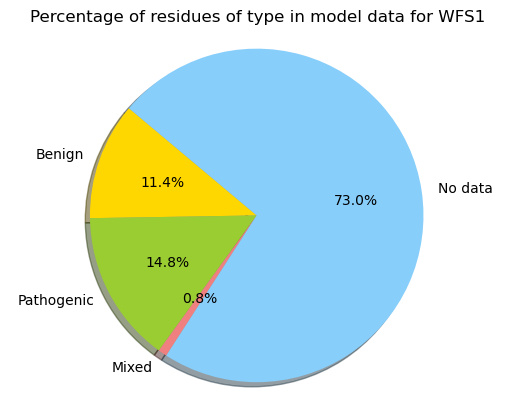

In [209]:
# Create a graph showing the percentage of each value in the bfactor dictionary
labels = ['Benign', 'Pathogenic', 'Mixed', 'No data']
sizes = [percentage_0, percentage_1, percentage_2, percentage_3]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice

plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.title(f'Percentage of residues of type in model data for {gene}')
# add title for each value
# plt.legend(labels, loc="best")
plt.axis('equal')
plt.show()